In [2]:
import numpy as np
from QAM_EncoderDecoder import * 
from scipy.io.wavfile import write, read
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from IPython.display import Audio
from scipy import interpolate, signal

%matplotlib inline

In [3]:
# constants

N = 2048
prefix_no = 256
fs = 44100

In [4]:
def random_symbols_from_binary(length, seed):
    """Returns a 'length'-long sequence of random constellation symbols"""

    rng = np.random.default_rng(seed)
    random_binary_sequence = rng.integers(low=0, high=2, size=2*length) # x2 as converting from binary to QPSK
    random_binary_values = np.split(random_binary_sequence, length)

    mapping = {
        '0 0':  1+1j,
        '0 1': -1+1j,
        '1 1': -1-1j,
        '1 0':  1-1j
    }

    random_symbols = [mapping[str(r)[1:-1]] for r in random_binary_values]
    
    return random_symbols

In [5]:
def define_chirp(sec):
    """returns standard log chirp waveform and its time-reverse"""
    
    k = 50
    w1 = 100
    w2 = 10000
    
    t = np.linspace(0, sec, int(fs*sec))
    
    ch = signal.chirp(t, f0=w1, f1=w2, t1=sec, method='logarithmic')
    ch *= (1-np.exp(-k*t))*(1-np.exp(-k*(sec-t)))
    
    ch /= 5 # scale so roughly same 'height' as OFDM blocks
    
    inv_ch = np.flip(ch)
    
    return ch, inv_ch

In [6]:
def create_OFDM_frame(seed):
    """Uses pseudo-random symbols to generate single known OFDM frame"""
    
    known_rand_symbols = random_symbols_from_binary(N//2-1, seed) # need 1023 symbols
    known_frame = np.zeros(N//2, dtype=complex)
    known_frame[1:] = known_rand_symbols
    known_frame = np.append(known_frame, np.append(0,np.conj(known_frame)[:0:-1]))
    known_frame = np.fft.ifft(known_frame)
    known_frame = np.real(known_frame)
    known_frame = np.append(known_frame[N-prefix_no:N], known_frame)
    
    return known_frame


In [7]:
def data_add_known_pilots(filename, min_bin, max_bin, pilot_params):
    """Given the range of bins to use and range of pilot indices, returns data with 1+1j pilot symbol
    insertions and random symbols in unused frequency bins"""

    frequency_filler = random_symbols_from_binary(N//2-1, 2023) # just filler symbols for unused freq. range excl. pilots
    
    # pilot_params = [start, stop, step]    
    pilot_value = 1+1j
    pilot_carriers = np.arange(pilot_params[0], pilot_params[1], pilot_params[2])
    
    all_carriers = np.arange(N//2)
    usable_carriers = np.arange(min_bin, max_bin)
    data_carriers = [x for x in usable_carriers if x not in pilot_carriers]
    
    data_bits = file_to_bitstr(filename) # uses QAM_Encoder_decoder file
    data_symbols= encode_bitstr2symbols(data_bits)
    carriers_required = int(np.ceil(len(data_symbols)/len(data_carriers)))
    
    OFDM_frames = []
    for i in range(0, carriers_required):

        frame = np.zeros(N//2, dtype=complex)
        frame[1:N//2-1] = frequency_filler[1:N//2-1]
        frame[pilot_carriers] = pilot_value        
        
        data_to_add = data_symbols[i*len(data_carriers):(i+1)*len(data_carriers)]
        frame[data_carriers[:len(data_to_add)]] = data_to_add

        frame = np.append(frame, np.append(0, np.conj(frame)[:0:-1]))
        OFDM_frame = np.real(np.fft.ifft(frame, N))
        OFDM_frame = np.append(OFDM_frame[N-prefix_no:N], OFDM_frame)

        OFDM_frames.append(OFDM_frame)
        
    return OFDM_frames, [pilot_carriers, data_carriers] , data_bits 


In [8]:
def create_tx_waveform(filename):
    """Creates waveform as described by the standard:
    1 sec chirp | Random OFDM block seed 2020 | 10 Known OFDM blocks seed 2021
    | Repeated payload consisting of *1 Random OFDM block seed 2022 and 10 data + pilot tone blocks* | 1 sec chirp
    Returns created waveform, the inverse chirp, num repeats, known frame"""
    
    ch, inv_ch = define_chirp(1) # need chirp for start & end
    random_frame_filler = create_OFDM_frame(2020) # single random frame used as a break between chirp & known OFDM
    
    repeats = 10 # num times known OFDM blocks are repeated
    known_frame = create_OFDM_frame(2021) # known frame, to be repeated, for channel estimation
    known_frames = np.tile(known_frame, repeats).ravel() # parallel to serial
    
    preamble_frame = create_OFDM_frame(2022) # preamble frame in front of 10 data frames
    
    min_bin = 50
    max_bin = 500
    pilot_params = [1, 1018, 8]
      
    data_frames, carrier_indices, data_bits  = data_add_known_pilots(filename, min_bin, max_bin, pilot_params)
    
    
    
    payloads_required = int(np.ceil(len(data_frames)/10))
    print(np.shape(data_frames), payloads_required)
    payload_frames = []
    
    
    for i in range(payloads_required):
        payload = np.concatenate((preamble_frame, data_frames[(i)*10:(i+1)*10]), axis=None)
        payload_frames = np.concatenate((payload_frames, payload), axis=None)
    
    payload_frames = data_frames

    
    gap = 1*fs # just to pad start & end of transmission
    tx_waveform = np.concatenate((np.zeros(gap), ch, random_frame_filler, known_frames, payload_frames, ch, np.zeros(gap)), axis=None)
    
    filename = 'sound_files/transmit.wav'
    sf.write(filename, tx_waveform, fs)
    
    return tx_waveform, inv_ch, ch, repeats, known_frame, carrier_indices, known_frames, data_frames, gap, random_frame_filler, payload_frames, data_bits

In [9]:
def ideal_channel_response(signal):
    """Returns channel output for tx signal"""
    
    channel = np.genfromtxt('Challenge/Week_1/channel.csv',delimiter=',')
    channel_op = np.convolve(signal, channel)
    
    return channel_op

def real_channel_response(signal):
    """Records and returns rx signal after writing to file"""
    
    wait_time = np.ceil(len(signal)/fs) + 1
    print("Recording for ", wait_time, " seconds")
    

    recording = sd.rec(int(wait_time * fs), samplerate=fs, channels=1)
    sd.wait()

    sf.write('sound_files/sync_long_rec.wav', recording, fs)

    print("Finished")
    recording = recording[:, 0]
    
    return recording 

def real_channel_response_file(rec_file):
    from pydub import AudioSegment
    recording = AudioSegment.from_file(rec_file)
    recording = recording.get_array_of_samples()
    channel_op = np.array(recording)
    return channel_op

In [10]:
def matched_filter(signal, match):
    """Returns convolution of signal with matched filter and its peak index"""
    
    convolution = np.convolve(signal, match)
    peak_index1 = np.argmax(np.abs(convolution[:len(convolution)//2])) # check 1st half of signal
    peak_index2 = np.argmax(np.abs(convolution[len(convolution)//2:])) + len(convolution)//2 # check 2nd half of signal
    
    return convolution, peak_index1, peak_index2

(7, 2304) 1


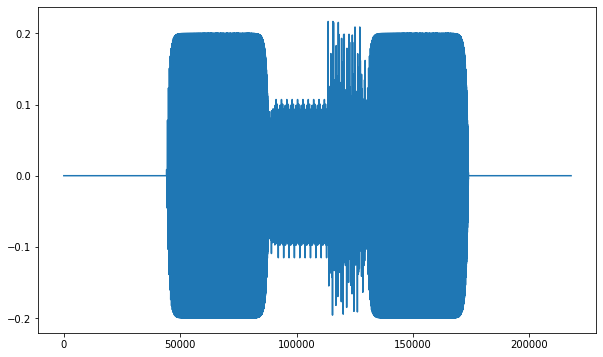

In [11]:
tx_signal, inverse_chirp,ch, repeats, known_frame, carrier_indices, known_frames, data_frames, gap, random_frame_filler, payload_frames, bits_tran = create_tx_waveform('test_files/Short_shakespeare.txt')
plt.figure(figsize=(10,6))
plt.plot(tx_signal)

sf.write('transmit.wav', tx_signal, fs)
#rx_signal = ideal_channel_response(tx_signal)



In [12]:
rx_signal = real_channel_response_file("sound_files/Rec37.m4a")

In [13]:
rx_convolution, peak_start, peak_end = matched_filter(rx_signal, inverse_chirp)

print("Peak start: ", peak_start)
print("Peak end: ", peak_end)


Peak start:  92415
Peak end:  177987


In [14]:
len(random_frame_filler)

2304

7

In [15]:

expected_ch_gap = len(known_frames) + len((payload_frames)) * 2304 + len(ch)  + len(random_frame_filler)
actual_ch_gap = peak_end - peak_start

print("Actual gap:", actual_ch_gap, "Expected:", expected_ch_gap)

sampling_ratio = actual_ch_gap / expected_ch_gap

print("Actual sampling frequency: ", 44100*sampling_ratio)
#print("Extra sample after every", int((1/(sampling_ratio-1))), "samples")

Actual gap: 85572 Expected: 85572
Actual sampling frequency:  44100.0


In [16]:
def channel_estimate(signal, start, repeats, known_frame, offset=0):
    """Given a signal and the index of the chirp end, calculates the channel frequency
    and impulse response"""
    
    start += N+prefix_no - offset # account for extra filler OFDM frame of length 2304
    length = (N+prefix_no) * repeats
    trimmed_frames = signal[start:start+length]
    split_frames = np.split(trimmed_frames, length/(N+prefix_no))
    
    average_frame = np.zeros(N+prefix_no)
    for frame in split_frames:     
        average_frame = np.add(average_frame, frame)
    average_frame /= (length/(N+prefix_no))
    
    known_frame = known_frame[prefix_no:]
    rx_known_frame = average_frame[prefix_no:]
    
    known_dft = np.fft.fft(known_frame, N)
    rx_known_dft = np.fft.fft(rx_known_frame, N)
    
    channel_freq_response = np.zeros(N//2, dtype=complex)
    np.divide(rx_known_dft[:N//2], known_dft[:N//2], out=channel_freq_response, where=known_dft[:N//2] != 0) # should catch divide by zero errors
    
    channel_freq_response = np.append(channel_freq_response, np.append(0,np.conj(channel_freq_response)[:0:-1]))
    
    channel_imp_response = np.fft.ifft(channel_freq_response, N)
    channel_imp_response = np.real(channel_imp_response)
    
    return channel_freq_response, channel_imp_response, split_frames
    
    

In [74]:
offset = 20

freq_response, imp_response, all_frames = channel_estimate(rx_signal, peak_start, repeats, known_frame, offset)

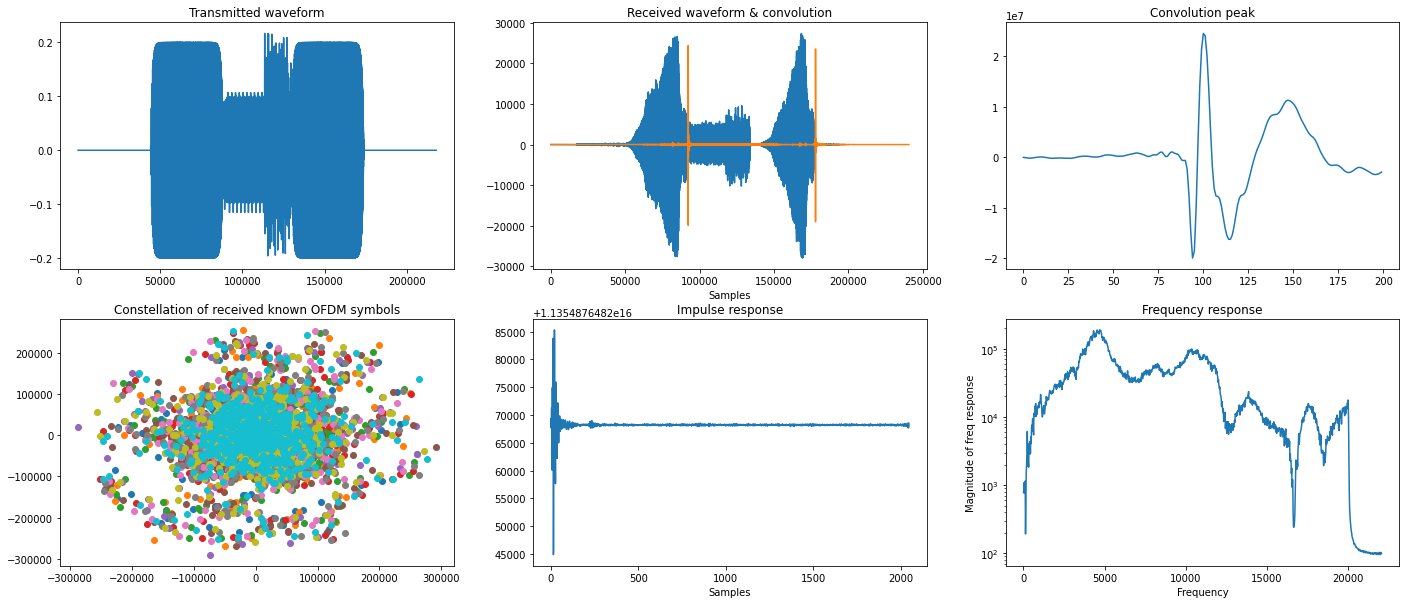

In [75]:
figs, axs = plt.subplots(2, 3, figsize=(24,10))
axs[0][0].plot(tx_signal)
axs[0][0].set_title('Transmitted waveform')
axs[0][1].plot(rx_signal)
axs[0][1].set_title('Received waveform & convolution')
axs[0][1].plot(rx_convolution/1000)
axs[0][1].set_xlabel('Samples')
axs[0][2].set_title('Convolution peak')
axs[0][2].plot(rx_convolution[peak_start-100:peak_start+100])

for i in range(len(all_frames)):
    tst_symbols = np.fft.fft(all_frames[i][prefix_no:], N)[1:N//2]
    axs[1][0].scatter(np.real(tst_symbols), np.imag(tst_symbols), label=i)
axs[1][0].set_title('Constellation of received known OFDM symbols')


axs[1][1].set_title('Impulse response')
axs[1][1].set_xlabel('Samples')
axs[1][1].plot(imp_response[:])
axs[1][2].set_title('Frequency response')
axs[1][2].set_ylabel('Magnitude of freq response')
axs[1][2].set_xlabel('Frequency')
axs[1][2].semilogy(np.linspace(1, fs//2 -1, N//2-2), np.abs(freq_response[1:N//2-1]))

In [68]:
offset_data = - offset

(7, 2304)


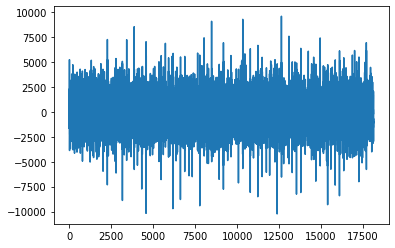

In [69]:
data_begin = peak_start + 11*(N+prefix_no) + offset_data # as 1 random & 10 known ofdm frames after chirp
data_end = peak_end - len(inverse_chirp) + offset_data # use end chirp to determine signal length for now, will need a fix later
# potential for data_being -> data_end to not be the correct length

rx_data_full = rx_signal[data_begin:data_end]
rx_data_frames = np.split(rx_data_full, int(len(rx_data_full)/(N+prefix_no)))
print(np.shape(rx_data_frames))
plt.plot(rx_signal[data_begin-1000:data_end+1000])

In [70]:
preamble_points = np.arange(0, len(rx_data_frames), 11)
just_data = np.delete(rx_data_frames, preamble_points, axis=0)
print(len(just_data))

6


In [71]:
def correct_phase_decode_data(all_frames, carrier_indices, channel_fft, filename, pilot_value=1+1j):
    
    pilot_indices = carrier_indices[0]
    data_indices = np.array(carrier_indices[1])
    
    pilot_symbols = []
    data_symbols = []
    
    preamble_points = np.arange(0, len(rx_data_frames), 11) # remove preamble frame before each set of 10 data blocks
    data_frames = np.delete(all_frames, preamble_points, axis=0)
    data_frames = all_frames

    bits = ""
    for i in range(len(data_frames)):
        
        frame_no_cp = data_frames[i][prefix_no:]
        frame_dft = np.fft.fft(frame_no_cp)

        pilots = frame_dft[pilot_indices]
        data = frame_dft[data_indices]
        
        pilots_demod = pilots / channel_fft[pilot_indices]
        pilots_phase_change = np.angle(pilots_demod / pilot_value) # divide by each known pilot symbol and get phase change
        
        phase_adjustment = np.polyfit(pilot_indices, np.unwrap(pilots_phase_change), 1)[0] # take gradient, intercept should be zero
        
        pilots *=  np.exp(-1j*phase_adjustment*pilot_indices)
        data *=  np.exp(-1j*phase_adjustment*data_indices)

        bits+=decode_symbols_2_bitstring(data, channel_fft[data_indices])
        
        pilot_symbols.append(pilots)
        data_symbols.append(data)
        
    bitstr_to_file(bits, filename)
    
    return data_symbols, pilot_symbols, bits

def error_rate(bits_tran, bits_rec):
    length = min(len(bits_tran),len(bits_tran))
    a1 = np.fromstring(bits_tran, 'u1') - ord('0')
    a2 = np.fromstring(bits_rec, 'u1') - ord('0')
    a2 = a2[0:length]
    return (length - np.sum(a1 == a2)) / length

In [72]:
data_symbols, pilot_symbols, bits_rec = correct_phase_decode_data(rx_data_frames, carrier_indices, freq_response, 'decoded_shakespeare.txt', 1+1j)


about to write file, the filename inputed is:  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt


In [73]:
error_rate(bits_tran, bits_rec)

<ipython-input-71-19fcda97e278>:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a1 = np.fromstring(bits_tran, 'u1') - ord('0')
<ipython-input-71-19fcda97e278>:42: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a2 = np.fromstring(bits_rec, 'u1') - ord('0')


0.4746517027863777

In [65]:
def test(offset, offset_data):

    freq_response, imp_response, all_frames = channel_estimate(rx_signal, peak_start, repeats, known_frame, offset)

    #offset_data = - offset

    data_begin = peak_start + 11*(N+prefix_no) - offset_data
    data_end = peak_end - len(inverse_chirp) - offset_data 
    rx_data_full = rx_signal[data_begin:data_end]
    rx_data_frames = np.split(rx_data_full, int(len(rx_data_full)/(N+prefix_no)))

    data_symbols, pilot_symbols, bits_rec = correct_phase_decode_data(rx_data_frames, carrier_indices, freq_response, 'decoded_shakespeare.txt', 1+1j)
    return error_rate(bits_tran, bits_rec)

In [48]:
test(20 , 20)

bitstr written to  decoded_shakespeare.txt
<ipython-input-42-19fcda97e278>:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a1 = np.fromstring(bits_tran, 'u1') - ord('0')
<ipython-input-42-19fcda97e278>:42: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a2 = np.fromstring(bits_rec, 'u1') - ord('0')


0.23626160990712075

In [49]:
list = []
for i in range(-20,20,1):
    for j in range(-20,20,1):
        list.append([i,j,test(i,j)])

.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr written to  decoded_shakespeare.txt
bitstr

In [50]:
list = np.array(list)
#np.sort(list, axis=0)

In [51]:
list

array([[-20.        , -20.        ,   0.33320433],
       [-20.        , -19.        ,   0.18266254],
       [-20.        , -18.        ,   0.19620743],
       ...,
       [ 19.        ,  17.        ,   0.19930341],
       [ 19.        ,  18.        ,   0.19291796],
       [ 19.        ,  19.        ,   0.16505418]])

In [52]:
list[np.argsort(list[:, 2])]

array([[ 1.10000000e+01,  1.00000000e+01,  1.76083591e-02],
       [-1.90000000e+01, -7.00000000e+00,  1.79953560e-02],
       [-1.40000000e+01, -3.00000000e+00,  1.95433437e-02],
       ...,
       [ 1.50000000e+01, -1.50000000e+01,  6.21323529e-01],
       [ 7.00000000e+00, -1.50000000e+01,  6.23258514e-01],
       [ 6.00000000e+00, -1.50000000e+01,  6.31191950e-01]])

In [53]:
test(10,10)

bitstr written to  decoded_shakespeare.txt
<ipython-input-42-19fcda97e278>:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a1 = np.fromstring(bits_tran, 'u1') - ord('0')
<ipython-input-42-19fcda97e278>:42: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a2 = np.fromstring(bits_rec, 'u1') - ord('0')


0.1561532507739938

In [54]:
test(20,20)

bitstr written to  decoded_shakespeare.txt
<ipython-input-42-19fcda97e278>:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a1 = np.fromstring(bits_tran, 'u1') - ord('0')
<ipython-input-42-19fcda97e278>:42: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a2 = np.fromstring(bits_rec, 'u1') - ord('0')


0.23626160990712075

In [75]:
test(18,18)

bitstr written to  decoded_shakespeare.txt
<ipython-input-58-19fcda97e278>:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a1 = np.fromstring(bits_tran, 'u1') - ord('0')
<ipython-input-58-19fcda97e278>:42: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a2 = np.fromstring(bits_rec, 'u1') - ord('0')


0.12093653250773993

In [72]:
np.delete(all_frames, preamble_points, axis=0)

array([[-2270,   -18,   945, ...,  -509,  -818, -1788],
       [-2500,  -667,   894, ...,  -821,  -935, -1837],
       [-3041,  -978,   563, ...,  -544, -1348, -1918],
       ...,
       [-2820,  -778,   751, ...,  -630,  -610, -1555],
       [-2207,  -283,   996, ...,  -933,  -987, -1555],
       [-2276,  -271,   874, ...,   398,   434,  1700]], dtype=int16)

In [134]:
np.delete([[1,2,3],[2,3,4],[3,4,5]], [0],axis=0)

array([[2, 3, 4],
       [3, 4, 5]])

In [140]:
all_frames[1].shape

(2304,)

In [142]:
len(all_frames)

10

In [143]:
all_frames

[array([ -983,   551,  1779, ...,   442, -1353, -2621], dtype=int16),
 array([-1891,   479,  1220, ...,   325, -1349, -2725], dtype=int16),
 array([-2084,   351,  1370, ...,   565, -1062, -2555], dtype=int16),
 array([-2087,   296,  1337, ...,   556, -1138, -2677], dtype=int16),
 array([-2382,   -28,  1135, ...,   384, -1392, -2703], dtype=int16),
 array([-2052,   376,  1335, ...,   439, -1088, -2396], dtype=int16),
 array([-2066,   282,  1473, ...,   417, -1277, -2837], dtype=int16),
 array([-2364,   203,  1208, ...,   524, -1056, -2658], dtype=int16),
 array([-2310,   291,  1376, ...,   560, -1146, -2708], dtype=int16),
 array([-2176,   313,  1291, ...,   747,  -205,   -60], dtype=int16)]